## Setup

In [1]:
!pip uninstall tensorflow -y
!pip install  tensorflow==2.15.0

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Successfully uninstalled tensorflow-2.15.0
  Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
Using cached tensorflow-2.15.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (475.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

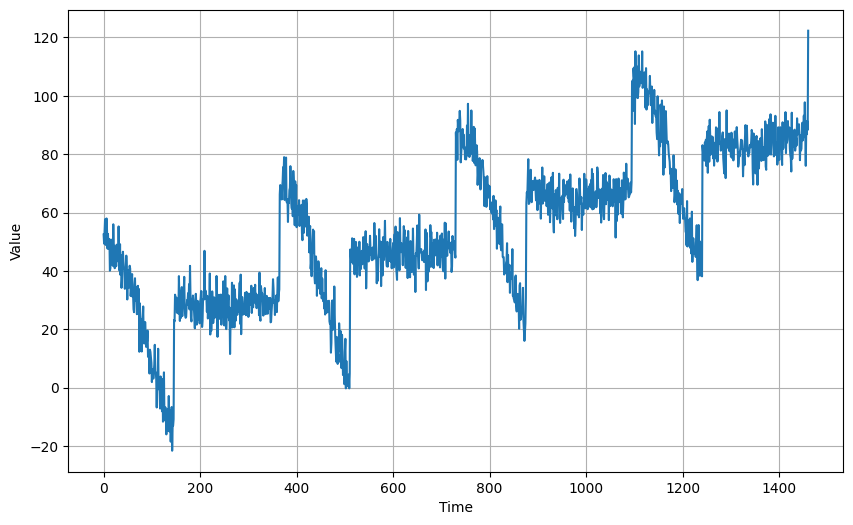

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Stateful RNN Forecasting

In [6]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [7]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [8]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 6s 25ms/step - loss: 41.3309 - mae: 41.8293 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 1s 24ms/step - loss: 19.3283 - mae: 19.8201 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 1s 27ms/step - loss: 16.3664 - mae: 16.8554 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 1s 18ms/step - loss: 15.1565 - mae: 15.6461 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 1s 23ms/step - loss: 14.4484 - mae: 14.9335 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 1s 21ms/step - loss: 14.0850 - mae: 14.5696 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 1s 23ms/step - loss: 13.9704 - mae: 14.4556 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 1s 21ms/step - loss: 13.9016 - mae: 14.3854 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 1s 21ms/step - loss: 13.8203 - mae:

(1e-08, 0.0001, 0.0, 30.0)

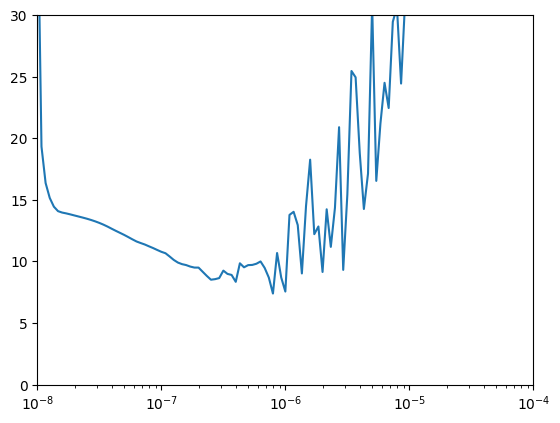

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [20]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(200, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
    keras.layers.Dropout(0.2),
    keras.layers.SimpleRNN(200, return_sequences=True, stateful=True),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

model.fit(train_set, epochs=500, validation_data=valid_set, callbacks=[ model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 4s 44ms/step - loss: 132.0365 - mae: 132.5351 - val_loss: 19.0401 - val_mae: 19.5371
Epoch 2/500
 4/33 [==>...........................] - ETA: 0s - loss: 114.3310 - mae: 114.8310

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 1s 33ms/step - loss: 107.4329 - mae: 107.9329 - val_loss: 19.0161 - val_mae: 19.5154
Epoch 3/500
33/33 [==============================] - 2s 53ms/step - loss: 109.4770 - mae: 109.9760 - val_loss: 21.8903 - val_mae: 22.3877
Epoch 4/500
33/33 [==============================] - 1s 28ms/step - loss: 103.0557 - mae: 103.5551 - val_loss: 30.6165 - val_mae: 31.1148
Epoch 5/500
33/33 [==============================] - 1s 28ms/step - loss: 105.1052 - mae: 105.6043 - val_loss: 19.6562 - val_mae: 20.1510
Epoch 6/500
33/33 [==============================] - 1s 27ms/step - loss: 99.7709 - mae: 100.2696 - val_loss: 18.9333 - val_mae: 19.4310
Epoch 7/500
33/33 [==============================] - 1s 30ms/step - loss: 94.8637 - mae: 95.3621 - val_loss: 14.4578 - val_mae: 14.9520
Epoch 8/500
33/33 [==============================] - 1s 30ms/step - loss: 97.0059 - mae: 97.5058 - val_loss: 8.7145 - val_mae: 9.2053
Epoch 9/500
33/33 [==============================] - 

In [21]:
model = keras.models.load_model("my_checkpoint.h5")

In [22]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time - 1:-1, 0]

1/1 [==============================] - 1s 957ms/step


In [23]:
rnn_forecast.shape

(461,)

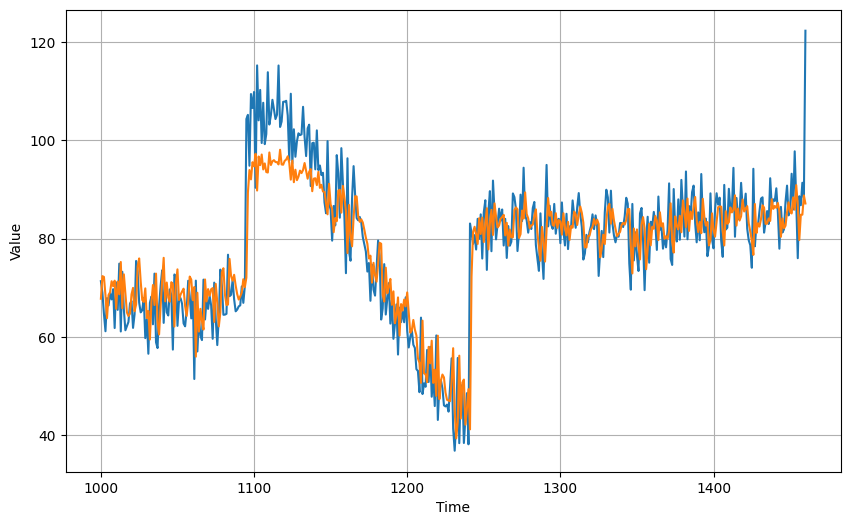

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [25]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.636406